In [10]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric._kernel_base import gpke
from statsmodels.nonparametric.kernels import gaussian, aitchison_aitken
from py_kernel_regression import loc_constant_fit, KernelReg as KR 

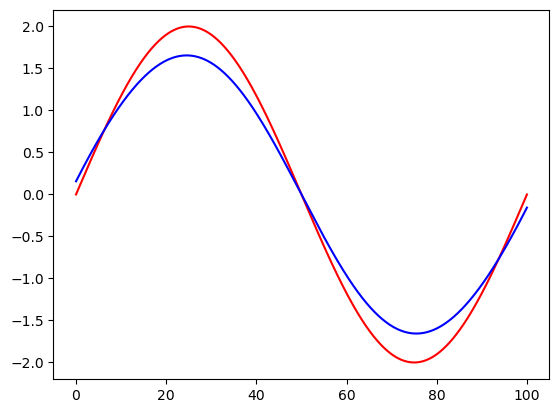

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
n = 1000 
x = np.linspace(0, 100, n)
y = np.array([2.0 * np.sin(x_i * np.pi/50) for x_i in x])

exog = x[:, None] 
predict = np.copy(x[:, None])
endog = y[:, None].ravel()

y_hat = KR([10.0], ["c"], "loc_linear").fit_predict(endog, exog, predict)
plt.plot(x, y, color="red")
plt.plot(x, y_hat, color="blue")


plt.savefig('./plots/ll_10_example.png')

In [12]:
## Try leave-one-out cross-validation
loss = KR([10.0], ["c"], "loc_linear").leave_one_out(endog, exog, "rmse")
loss

0.23287429887547298

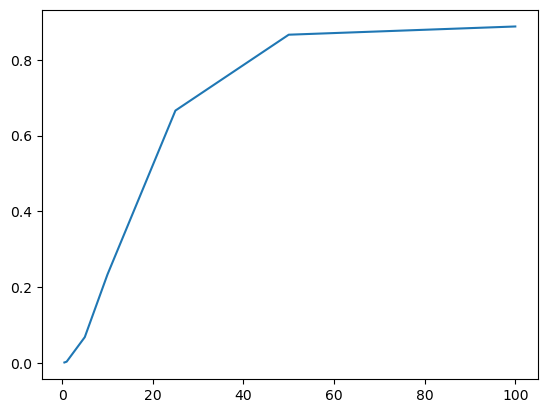

In [15]:
grid_bw = [0.5, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0]
losses = []
for bw in grid_bw:
    loss = KR([bw], ["c"], "loc_linear").leave_one_out(endog, exog, "rmse")
    losses.append(loss)
    
plt.plot(grid_bw, losses)

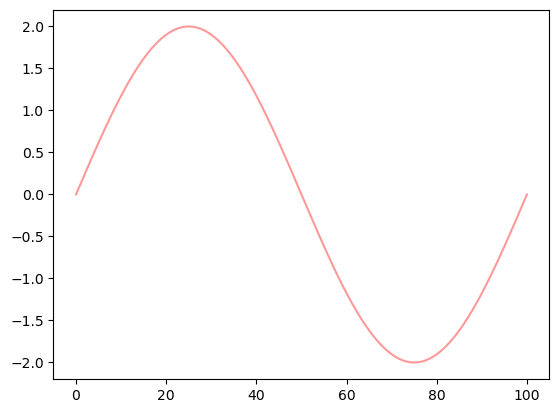

In [25]:
y_hat = KR([np.argmin(grid_bw)], ["c"], "loc_linear").fit_predict(endog, exog, predict)

plt.plot(x, y, color="red", alpha=.4)
plt.plot(x, y_hat, color="blue")

plt.savefig('./plots/ll_cv_example.png')

## Check bandwidth estimation

In [35]:
y_hat = mod.fit()[0]
# y_hat

In [37]:
def _est_loc_linear_weight(self, bw, exog, data_predict, index):
    nobs, k_vars = exog.shape
    ker = gpke(bw, data=exog, data_predict=data_predict,
               var_type=self.var_type,
               ckertype=self.ckertype,
               ukertype=self.ukertype,
               okertype=self.okertype,
               tosum=False) / float(nobs)
    # Create the matrix on p.492 in [7], after the multiplication w/ K_h,ij
    # See also p. 38 in [2]
    #ix_cont = np.arange(self.k_vars)  # Use all vars instead of continuous only
    # Note: because ix_cont was defined here such that it selected all
    # columns, I removed the indexing with it from exog/data_predict.

    # Convert ker to a 2-D array to make matrix operations below work
    ker = ker[:, np.newaxis]
    
    e_i = np.zeros((nobs, 1))
    e_i[index, 0] = 1.0
    
    M12 = exog - data_predict
    M22 = np.dot(M12.T, M12 * ker)
    M12 = (M12 * ker).sum(axis=0)
    M = np.empty((k_vars + 1, k_vars + 1))
    M[0, 0] = ker.sum()
    M[0, 1:] = M12
    M[1:, 0] = M12
    M[1:, 1:] = M22

    ker_e = ker * e_i 
    V = np.empty((k_vars + 1, 1))
    V[0, 0] = ker_e.sum()
    V[1:, 0] = ((exog - data_predict) * ker_e).sum(axis=0)

    mean_mfx = np.dot(np.linalg.pinv(M), V)
    mean = mean_mfx[0]
    mfx = mean_mfx[1:, :]
    return mean, mfx

KernelReg._est_loc_linear_weight = _est_loc_linear_weight

In [38]:
mod = sm.nonparametric.KernelReg(endog, exog, var_type='c', reg_type='ll', bw=[10.0])

In [36]:
_est_loc_linear_weight(mod, bw=np.array([10.0]), exog=exog, data_predict=exog, index=0)

TypeError: only integer scalar arrays can be converted to a scalar index